<a href="https://colab.research.google.com/github/Xergon-sci/Predicting-chemical-hardness-A-study-using-machine-learning-and-artificial-neural-networks/blob/master/Similarity_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.6/site-packages to PYTHONPATH
python version: 3.6.9
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit
done
rdkit-2020.03.3 installation finished!


In [ ]:
import pandas as pd
from rdkit import Chem, DataStructs
import numpy as np
from scipy.spatial.distance import euclidean

# Load data
df = pd.read_table("/content/drive/My Drive/vub/dataset_R.txt", sep='\t')

In [ ]:
# Group < 3
l3_RAW = df.loc[df['n'] < 3]
l3 = l3_RAW.reset_index()
l3 = l3['smiles']

# Group > 6
g6_RAW = df.loc[df['n'] > 6]
g6 = g6_RAW.reset_index()
g6 = g6['smiles']

# Reference group
gr_RAW = df.loc[(df['n'] >= 3) & (df['n'] <= 6)]
gr = gr_RAW.reset_index()
gr = gr['smiles']

# Outliers
outliers = df.iloc[[7,69,274,391,404,647,944,1334,1579,1604,1637,2309,2675,2755,2773,2881,2884,2949,3032,3716,4121,4242,4369,4471,4620,4816], 1]
outliers = outliers.reset_index()
outliers = outliers['smiles']

# Rdkit Based

## Functions

In [ ]:
def FindSimilaritiesFromSmiles(reference, comparables):
  
  mRef = Chem.MolFromSmiles(reference)
  ref = Chem.RDKFingerprint(mRef)

  comp = []

  print('Generating fingerprints...')
  for c in comparables:
    m = Chem.MolFromSmiles(c)
    comp.append(Chem.RDKFingerprint(m))
  print('Fingerprints generated.')
  
  results = []

  print('Checking for similarities...')
  for x in comp:
    results.append(DataStructs.TanimotoSimilarity(ref, x))
  print('Check Complete.')
  
  return results

def FindSimilaritiesForList(reference, comparables):
  results = []
  i = 1
  
  for m in reference:
    print('----- {} -----'.format(i))
    results.append(FindSimilaritiesFromSmiles(m, comparables))
    i = i+1
  
  results = pd.DataFrame(results)

  return results

## Calculations

In [ ]:
# Group < 3 v 3-6
l3Results = FindSimilaritiesForList(l3, gr)
l3Results = pd.DataFrame(l3Results)
l3Results.to_excel("Results_Lower_Group.xlsx")

In [ ]:
# Group > 6 v 3-6
g6Results = FindSimilaritiesForList(g6, gr)
g6Results = pd.DataFrame(g6Results)
g6Results.to_excel("Results_Upper_Group.xlsx")

In [ ]:
# Outliers v 3-6
outliersResults = FindSimilaritiesForList(outliers, gr)
outliersResults = pd.DataFrame(outliersResults)
outliersResults.to_excel("Results_Outliers.xlsx")

In [ ]:
# Group < 3 v < 3
l3vl3Results = FindSimilaritiesForList(l3, l3)
l3vl3Results = pd.DataFrame(l3vl3Results)
l3vl3Results.to_excel("Results_l3vl3.xlsx")

In [ ]:
# Group > 6 v > 6
g6vg6Results = FindSimilaritiesForList(g6, g6)
g6vg6Results = pd.DataFrame(g6vg6Results)
g6vg6Results.to_excel("Results_g6vg6.xlsx")

# MQN Based

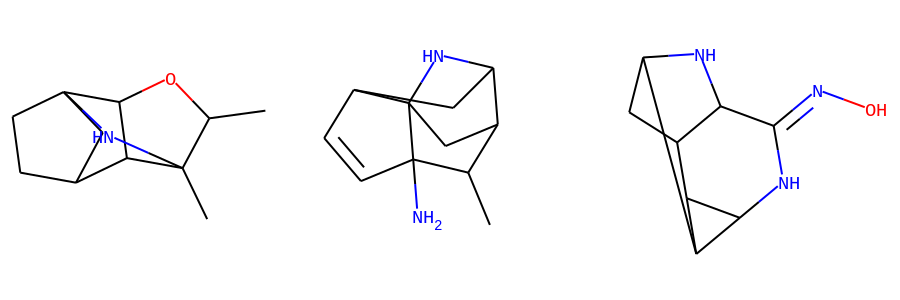

In [ ]:
from rdkit.Chem import Draw

dm = []
dm.append(Chem.MolFromSmiles('CC1OC2C3C4CCC2(C4)NC13C'))
dm.append(Chem.MolFromSmiles('CC1C2CC34NC2CC3C=CC14N'))
dm.append(Chem.MolFromSmiles('ON=C1NC2C3C2C2CC3NC12'))

Chem.Draw.MolsToGridImage(dm, molsPerRow=3, subImgSize=(300,300))

## Functions

In [ ]:
def NormalizeValue(value, upperBound, lowerbound=0):
  r = upperBound - lowerbound

  if r == 0:
    result = 0
  else:
    result = np.absolute((value - r) / r)
  return result

def NormalizeMQN(MQN):
  result = []

  result.append(NormalizeValue(MQN[0],13))  # Carbon
  result.append(NormalizeValue(MQN[1],0))  # Fluorine
  result.append(NormalizeValue(MQN[2],1))  # Chlorine
  result.append(NormalizeValue(MQN[3],0))  # Bromine
  result.append(NormalizeValue(MQN[4],0))  # Iodine
  result.append(NormalizeValue(MQN[5],2))  # Sulfur
  result.append(NormalizeValue(MQN[6],0))  # Phosphorous
  result.append(NormalizeValue(MQN[7],5))  # Acyclic nitrogen
  result.append(NormalizeValue(MQN[8],5))  # Cyclic nitrogen
  result.append(NormalizeValue(MQN[9],5))  # Acyclic oxygen
  result.append(NormalizeValue(MQN[10],4))  # Cyclic oxygen
  result.append(NormalizeValue(MQN[11],17))  # Heavy atoms
  result.append(NormalizeValue(MQN[12],12))  # Acyclic single bonds
  result.append(NormalizeValue(MQN[13],5))  # Acyclic double bonds
  result.append(NormalizeValue(MQN[14],3))  # Acyclic triple bonds
  result.append(NormalizeValue(MQN[15],18))  # Cyclic single bonds
  result.append(NormalizeValue(MQN[16],6))  # Cyclic double bonds
  result.append(NormalizeValue(MQN[17],2))  # Cyclic triple bonds
  result.append(NormalizeValue(MQN[18],8))  # Rotable bonds
  result.append(NormalizeValue(MQN[19],12))  # H-bond acceptor sites
  result.append(NormalizeValue(MQN[20],7))  # H-bond acceptor atoms
  result.append(NormalizeValue(MQN[21],10))  # H-bond donor sites
  result.append(NormalizeValue(MQN[22],5))  # H-bond donor atoms
  result.append(NormalizeValue(MQN[23],1))  # Negative charges
  result.append(NormalizeValue(MQN[24],1))  # Positive charges
  result.append(NormalizeValue(MQN[25],8))  # Acyclic single valent nodes
  result.append(NormalizeValue(MQN[26],11))  # Acyclic divalent nodes
  result.append(NormalizeValue(MQN[27],5))  # Acyclic trivalent nodes
  result.append(NormalizeValue(MQN[28],2))  # Acyclic tetravalent nodes
  result.append(NormalizeValue(MQN[29],13))  # Cyclic divalent nodes
  result.append(NormalizeValue(MQN[30],10))  # Cyclic trivalent nodes
  result.append(NormalizeValue(MQN[31],4))  # Cyclic tetravalent nodes
  result.append(NormalizeValue(MQN[32],3))  # 3-membered rings
  result.append(NormalizeValue(MQN[33],2))  # 4-membered rings
  result.append(NormalizeValue(MQN[34],6))  # 5-membered rings
  result.append(NormalizeValue(MQN[35],5))  # 6-membered rings
  result.append(NormalizeValue(MQN[36],4))  # 7-membered rings
  result.append(NormalizeValue(MQN[37],4))  # 8-membered rings
  result.append(NormalizeValue(MQN[38],2))  # 9-membered rings
  result.append(NormalizeValue(MQN[39],2))  # >= 10-membered rings
  result.append(NormalizeValue(MQN[40],12))  # nodes shared by >= 2 rings
  result.append(NormalizeValue(MQN[41],15))  # edges shared by >= 2 rings
  return np.array(result)

def ConstructMQNVectors(df):
  mqndf = df.iloc[:,2:44]
  mqndf = mqndf.reset_index()
  mqndf = mqndf.drop(columns=['index'])

  result = mqndf.to_numpy()
  return result
  
def CompareMQN(reference, comparable):
  diff = np.subtract(reference, comparable)
  absol = np.absolute(diff)
  result = np.sum(absol)
  
  return result

def CompareMQN_V2(reference, comparable):
  nRef = NormalizeMQN(reference)
  nComp = NormalizeMQN(comparable)

  diff = np.subtract(nRef, nComp)
  result = np.sum(diff**2)
  return result

def CompareMQN_V3(reference, comparable):
  result = euclidean(reference, comparable)
  return result

def FindSimilaritiesFromMQN(reference, comparables, MQN_version=2):
  results = []

  print('Checking for similarities...')
  for x in comparables:
    if MQN_version == 1:
      results.append(CompareMQN(reference, x))
    elif MQN_version == 2:
      results.append(CompareMQN_V2(reference, x))
    elif MQN_version == 3:
      results.append(CompareMQN_V3(reference, x))

  print('Check Complete.')
  
  return results

def FindSimilaritiesFromMQNList(references, comparables, MQN_version=2):
  results = []
  i = 1
  
  for mqn in references:
    print('----- {} -----'.format(i))
    results.append(FindSimilaritiesFromMQN(mqn, comparables, MQN_version))
    i = i+1
  
  results = pd.DataFrame(results)

  return results

## Calculations

In [ ]:
outliers_RAW = df.iloc[[7,69,274,391,404,647,944,1334,1579,1604,1637,2309,2675,2755,2773,2881,2884,2949,3032,3716,4121,4242,4369,4471,4620,4816],:]

l3_MQN = ConstructMQNVectors(l3_RAW)
g6_MQN = ConstructMQNVectors(g6_RAW)
gr_MQN = ConstructMQNVectors(gr_RAW)
outliers_MQN = ConstructMQNVectors(outliers_RAW)

In [ ]:
# Group < 3 v 3-6
l3_MQN_Results = FindSimilaritiesFromMQNList(l3_MQN, gr_MQN, 1)
l3_MQN_Results = pd.DataFrame(l3_MQN_Results)
l3_MQN_Results.to_excel("MQN_Results_Lower_Group.xlsx")

In [ ]:
# Group > 6 v 3-6
g6_MQN_Results = FindSimilaritiesFromMQNList(g6_MQN, gr_MQN, 1)
g6_MQN_Results = pd.DataFrame(g6_MQN_Results)
g6_MQN_Results.to_excel("MQN_Results_Upper_Group.xlsx")

In [ ]:
# Outliers v 3-6
outliers_MQN_Results = FindSimilaritiesFromMQNList(outliers_MQN, gr_MQN, 1)
outliers_MQN_Results = pd.DataFrame(outliers_MQN_Results)
outliers_MQN_Results.to_excel("MQN_Results_Outliers.xlsx")

In [ ]:
# Group < 3 v < 3
l3vl3_MQN_Results = FindSimilaritiesFromMQNList(l3_MQN, l3_MQN, 2)
l3vl3_MQN_Results = pd.DataFrame(l3vl3_MQN_Results)
l3vl3_MQN_Results.to_excel("MQN_Results_l3vl3.xlsx")

In [ ]:
# Group > 6 v > 6
g6vg6_MQN_Results = FindSimilaritiesFromMQNList(g6_MQN, g6_MQN, 2)
g6vg6_MQN_Results = pd.DataFrame(g6vg6_MQN_Results)
g6vg6_MQN_Results.to_excel("MQN_Results_g6vg6.xlsx")

In [ ]:
# Group < 3 v < 3
l3vl3_MQN_Results = FindSimilaritiesFromMQNList(l3_MQN, l3_MQN, 3)
l3vl3_MQN_Results = pd.DataFrame(l3vl3_MQN_Results)
l3vl3_MQN_Results.to_excel("MQN_Results_l3vl3.xlsx")

In [ ]:
# Group > 6 v > 6
g6vg6_MQN_Results = FindSimilaritiesFromMQNList(g6_MQN, g6_MQN, 3)
g6vg6_MQN_Results = pd.DataFrame(g6vg6_MQN_Results)
g6vg6_MQN_Results.to_excel("MQN_Results_g6vg6.xlsx")

----- 1 -----
Checking for similarities...
Check Complete.
----- 2 -----
Checking for similarities...
Check Complete.
----- 3 -----
Checking for similarities...
Check Complete.
----- 4 -----
Checking for similarities...
Check Complete.
----- 5 -----
Checking for similarities...
Check Complete.
----- 6 -----
Checking for similarities...
Check Complete.
----- 7 -----
Checking for similarities...
Check Complete.
----- 8 -----
Checking for similarities...
Check Complete.
----- 9 -----
Checking for similarities...
Check Complete.
----- 10 -----
Checking for similarities...
Check Complete.
----- 11 -----
Checking for similarities...
Check Complete.
----- 12 -----
Checking for similarities...
Check Complete.
----- 13 -----
Checking for similarities...
Check Complete.
----- 14 -----
Checking for similarities...
Check Complete.
----- 15 -----
Checking for similarities...
Check Complete.
----- 16 -----
Checking for similarities...
Check Complete.
----- 17 -----
Checking for similarities...
Check

In [ ]:
import matplotlib.pyplot as plt

l3_RAW['Carbon'].mean()
l3_RAW['Carbon'].mean()

9.933333333333334

In [ ]:
gr_RAW.to_excel('gr.xlsx')